# Style Transfer
The notes to this notebook can be found [here](https://lauradang.gitbook.io/notes/machine-learning/convolutional-neural-networks/style-transfer).

In [46]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from tqdm.notebook import tqdm
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import imageio
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

## Hyperparameters
As described in the paper, there are some weights and constants that must be predefined for the loss functions.

In [0]:
STYLE_WEIGHTS = {
    "conv1_1": 1,
    "conv2_1": 0.8,
    "conv3_1": 0.5,
    "conv4_1": 0.3,
    "conv5_1": 0.1
}

CONTENT_WEIGHT = 1 # Alpha
STYLE_WEIGHT = 100000000 # Beta

LEARNING_RATE = 0.01
STEPS = 3000 # Iterations to update image

## Helper Functions
These functions can help us complete the style transfer process.

In [0]:
ROOT = "/content/gdrive/My Drive/Colab Notebooks/pytorch-udacity-course"
STYLE_IMG = f"{ROOT}/GuylasPainting.jpeg"
CONTENT_IMG = f"{ROOT}/lion.jpg"

In [0]:
def load_image(img_path, max_size=400, shape=None):
    """
    Load in and transform an image, making sure the image
    is <= 400 pixels in the x-y dims to reduce computational load.
    
    Parameters:
      img_path: The path of the image.
      max_size: The size restriction on the image.
      shape: The dimensions that the image should have.
    
    Returns:
      The resized image as a tensor.
    """
    image = Image.open(img_path).convert("RGB")
    
    if shape is not None:
      size = shape
    else:
      size = max_size if max(image.size) > max_size else max(image.size)
        
    in_transform = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # Discard transparent, alpha channel (that's the :3)
    # Add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

In [0]:
def tensor_to_image(tensor):
    """
    Display a tensor as an image.

    Parameters:
      tensor: The tensor that represents the image.

    Returns:
      The tensor in a form where plt.imshow can display an image.
    """
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

For the this helper function, we get the layers from the paper's results. If we print out `vgg`, the index of the layers and the layers will be output. So we just want to create a dictionary called `layers` that maps the layers we need for this task back to its respective index as it is in the original `vgg` model.

In [0]:
def get_features(image_tensor, model, layers=None):
  """
  Run an image tensor forward through a model and get the features for a set of layers.

  Parameters:
    image_tensor: The image tensor that is being run forward through the model.
    model: The VGG model in this case.
    layers: The layers where features will be extracted. If this is none, it
            will be defaulted to the VGG layers specified in the paper.
  
  Returns:
    The features that are extracted from the layers as a dictionary like so:
    {conv1_1: <image_tensor>, conv2_1: <image_tensor>, etc.}
  """
  if layers is None:
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1', 
        '10': 'conv3_1', 
        '19': 'conv4_1',
        '21': 'conv4_2', # content representation
        '28': 'conv5_1'
    }
  
  features = {}

  for name, layer in model._modules.items():
      layer = layer.to(device)
      image_tensor = layer(image_tensor)
      if name in layers:
          features[layers[name]] = image_tensor

  return features

In [0]:
def gram_matrix(tensor):
  """
  Calculates the gram matrix from a given 4D tensor.

  Parameters:
    tensor: The 4D tensor.

  Returns:
    The gram matrix.
  """
  bs, depth, height, width = tensor.shape

  # Flatten tensor to 2D matrix
  tensor = tensor.view(depth, height * width)

  # Calculate the gram matrix by multiplying the transpose of the tensor
  gram = torch.mm(tensor, tensor.t())

  return gram

## Loading in VGG
We do not need the classification layers in this model, so only loading and freezing the features is good enough.

**Note**: 
- `vgg19.features`: Convolutional and pooling layers
- `vgg19.classifier`: Classification layers

In [0]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad = False

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Images

Style Image Size: (2498, 3284)
Content Image Size: (425, 282)


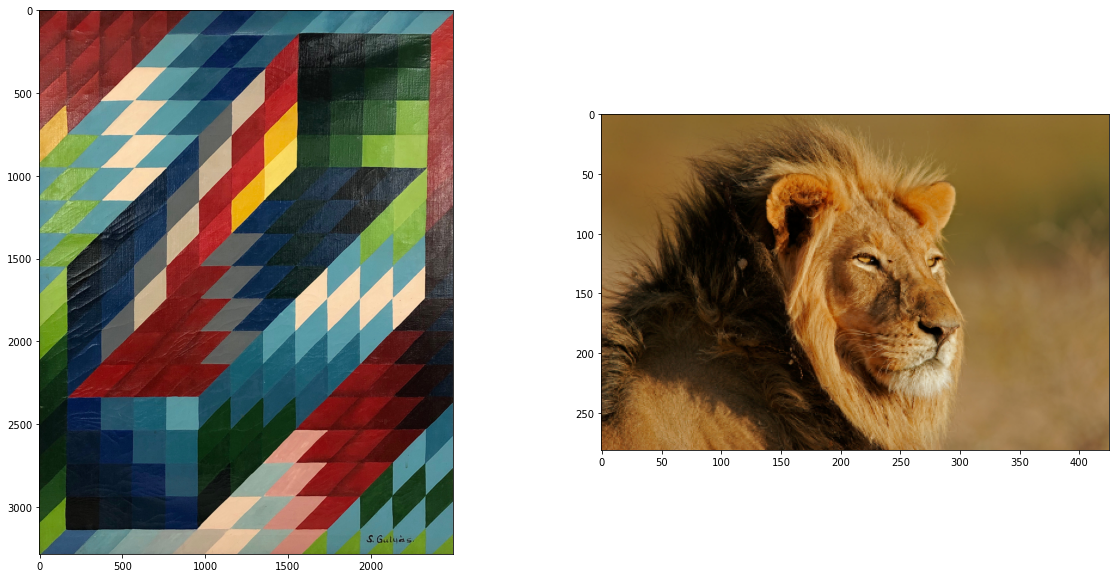

In [56]:
style_img = Image.open(STYLE_IMG).convert("RGB")
content_img = Image.open(CONTENT_IMG).convert("RGB")
print(f"Style Image Size: {style_img.size}")
print(f"Content Image Size: {content_img.size}")

f, axarr = plt.subplots(1, 2, figsize=(20, 10))
axarr[0].imshow(style_img)
axarr[1].imshow(content_img)

In [57]:
content = load_image(CONTENT_IMG).to(device)
# Want to match content shape
style = load_image(STYLE_IMG, shape=content.shape[-2:]).to(device)
print(content.shape)
print(style.shape)

torch.Size([1, 3, 400, 602])
torch.Size([1, 3, 400, 602])


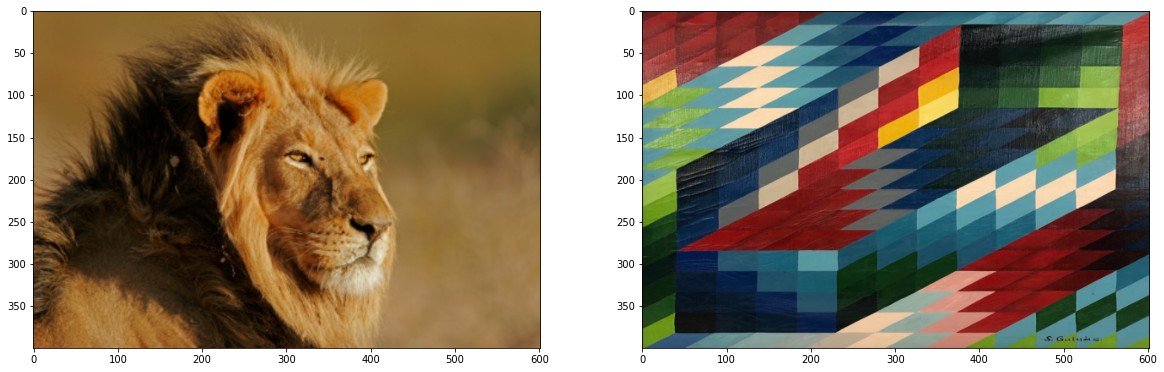

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(tensor_to_image(content))
ax2.imshow(tensor_to_image(style))

## Content and Style Features
So now we can retrieve the features within those convolutional layers and calculate the gram matrices on each of them.


In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

This calculates the gram matrix for each image tensor stored in a layer key in `style_features`.

In [0]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

It's a good idea to start with the actual image as the content image, and then iteratively change it based on the given style image.

In [0]:
target_content = content.clone().requires_grad_(True).to(device)

## Updating Target while Calculating Loss
This is similar to the traditional training loops we have seen before. However, no parameters in the `vgg` model are being changed. We are only changing the *target image* with each iteration.

Inside the iteration loop, two things will happen:
1. Calculate the content and style losses 
2. Update the target image, accordingly

Here are the loss functions:
$$L_{content}=\frac{1}{2}\Sigma(T_c-C_c)^2$$
$$L_{style} = a\space \Sigma \space w_i(T_{s,i}-S_{s,i})^2$$
$$L_{total} = \alpha L_{content}+\beta L_{style}$$

Total loss:  1211675392.0


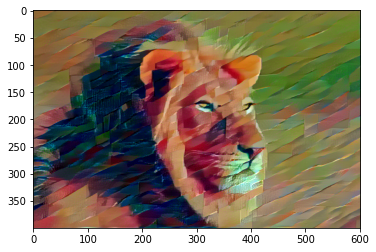

Total loss:  456798496.0


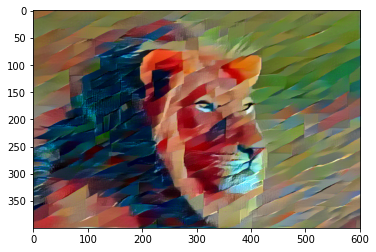

Total loss:  226166320.0


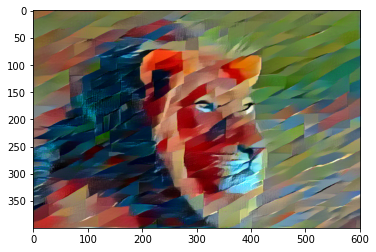

Total loss:  138547344.0


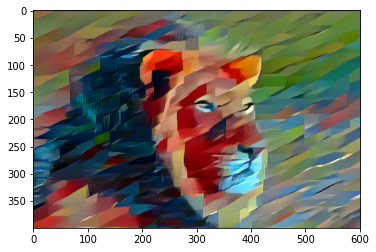

Total loss:  96647864.0


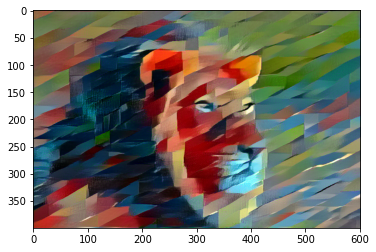

Total loss:  73119288.0


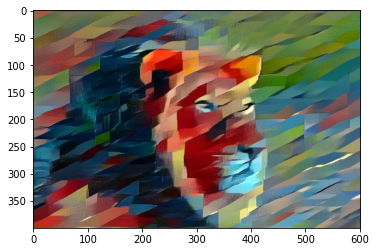

Total loss:  57096684.0


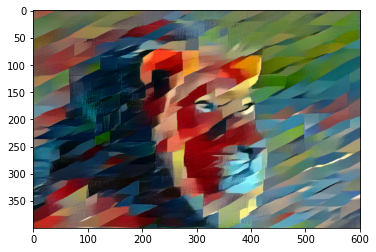

In [64]:
display_img_iter = 400
optimizer = optim.Adam([target_content], lr=LEARNING_RATE)

for i in tqdm(range(1, STEPS+1), desc="Step"):
    target_features = get_features(target_content, vgg)
    content_loss = torch.mean(
        (target_features["conv4_2"] - content_features["conv4_2"])**2
    )
    style_loss = 0

    for layer in STYLE_WEIGHTS:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)

        batch_size, depth, height, width = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = STYLE_WEIGHTS[layer] * torch.mean(
            (target_gram - style_gram)**2
        )

        # Divide by dimensions to normalize loss
        style_loss += layer_style_loss / (depth * height * width)
        
    total_loss = CONTENT_WEIGHT * content_loss + STYLE_WEIGHT * style_loss
    
    optimizer.zero_grad() 
    total_loss.backward() # Gradient cumulates
    optimizer.step() # Parameters for target_content are updated
    
    if i % display_img_iter == 0:
        print("Total loss: ", total_loss.item())
        plt.imshow(tensor_to_image(target_content))
        plt.show()

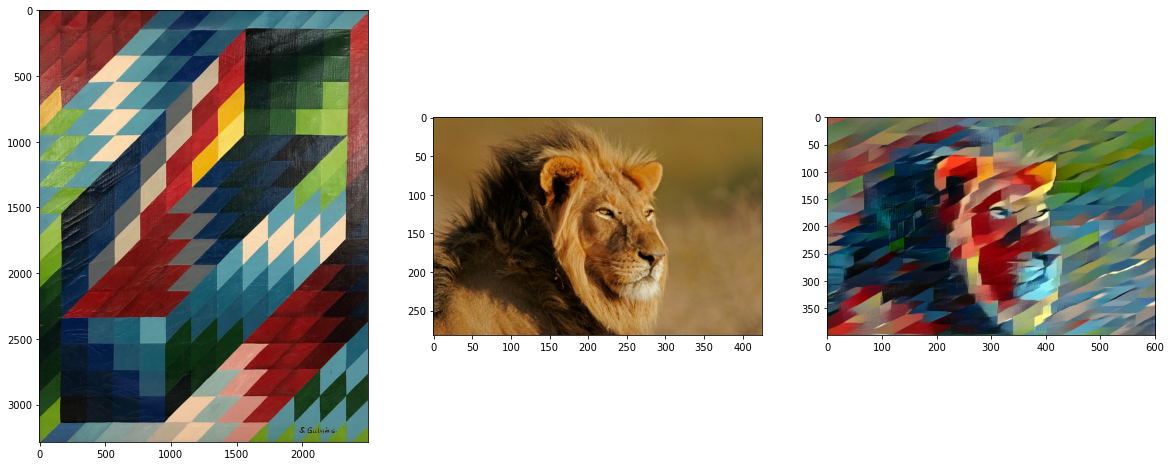

In [65]:
f, axarr = plt.subplots(1, 3, figsize=(20, 10))
axarr[0].imshow(style_img)
axarr[1].imshow(content_img)
axarr[2].imshow(tensor_to_image(target_content))

In [0]:
# new_img = f"{ROOT}/lion-style.png"
# target_img = tensor_to_image(target_content)
# imageio.imwrite(new_img, target_img) 